In [1]:
from ipynb.fs.full.helper_functions import *
from ipynb.fs.defs.helper_functions import *
from sklearn.model_selection import train_test_split , StratifiedShuffleSplit
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [3]:
from scipy.stats import stats
from sklearn.model_selection import RandomizedSearchCV


In [4]:
housing = load_housing_data()

In [5]:
housing.head(6)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


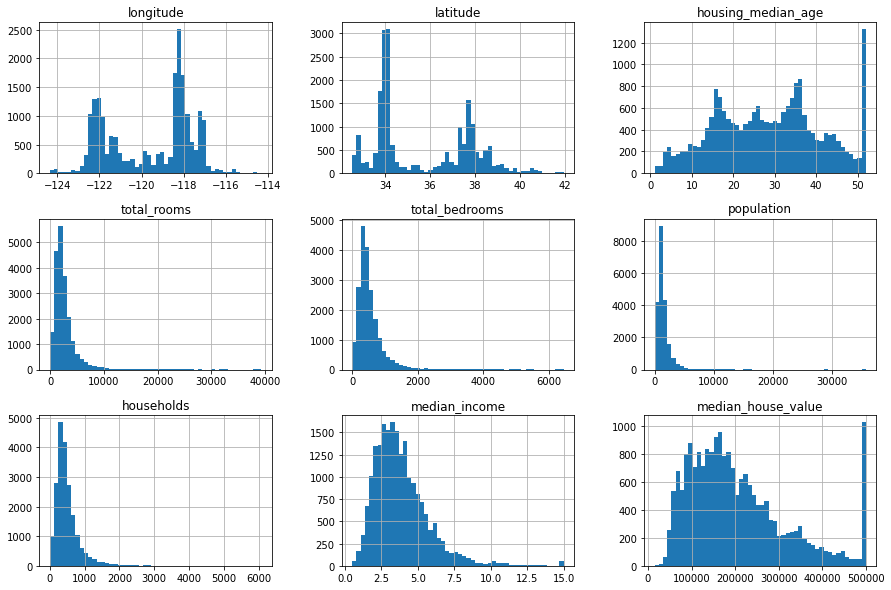

In [8]:
housing.hist(bins=50 , figsize = (15,10)) 
plt.show()

#### We are going to creat stratified test set based on median income 


In [9]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0.,1.5, 3.0, 4.5, 6., np.inf], labels = [1,2,3,4,5])
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat" , axis = 1 , inplace = True)

In [10]:
housing = strat_train_set.copy()

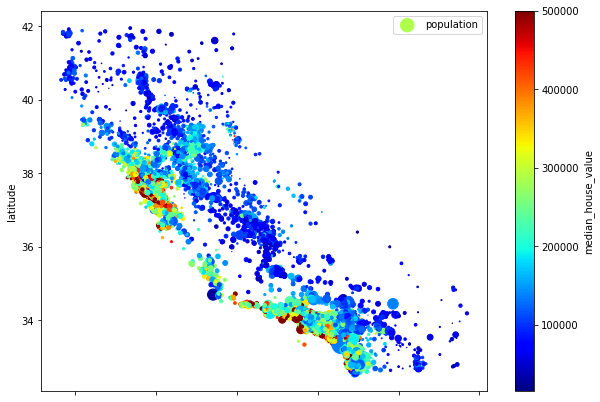

In [11]:
housing.plot(kind = "scatter" , x = "longitude" , y = "latitude" , s = housing["population"]/100
           ,label = "population" , figsize = (10,7) , c = "median_house_value" , cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()
plt.show()

In [12]:
corr_matrix = housing.corr()

In [13]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

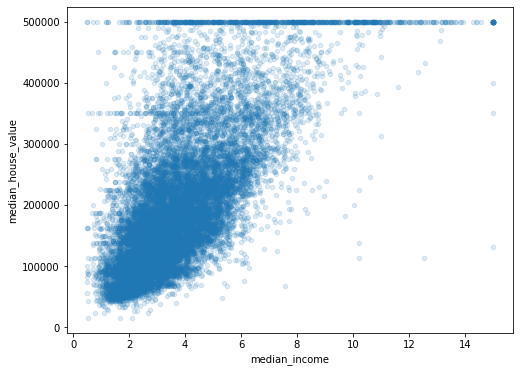

In [16]:
housing.plot(kind = "scatter" , x = "median_income" , y = "median_house_value", figsize = (8,6) , alpha = 0.15)
plt.show()

#### Creating useful new attributes

In [17]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [16]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [18]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()
housing_num = strat_train_set.drop(["median_house_value","ocean_proximity"], axis = 1)

In [19]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [20]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline,num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [21]:
housing_prepared = full_pipeline.fit_transform(housing)

In [22]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [23]:
svr_reg = SVR()
svr_reg.fit(housing_prepared,housing_labels)

SVR()

In [24]:
housing_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels,housing_predictions)
svr_mse = np.sqrt(svr_mse)
svr_mse

118580.68301157995

In [25]:
scores = cross_val_score(svr_reg , housing_prepared, housing_labels ,
                        scoring = "neg_mean_squared_error", cv = 10)
svr_rmse_scores = np.sqrt(-scores)

In [26]:
display_scores(svr_rmse_scores)

Scores :  [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean :  118572.66762937943
Standard deviation :  2936.8775867949425


#### Fine Tuning 

In [29]:
# Grid Search 
params_grid = [{'kernel':['linear'],'C':[1000,3000,10000,30000]},
               {'kernel':['rbf'], 'C':[1000,3000,10000,30000],'gamma':[0.1,0.3,1]},
              ]

In [32]:
# grid_search = RandomizedSearchCV(svr_reg, params_grid,cv=5,scoring='neg_mean_squared_error', return_train_score=True)
n_iter_search = 10
grid_search = RandomizedSearchCV(
    svr_reg, param_distributions=params_grid, n_iter=n_iter_search,cv=5,scoring = 'neg_mean_squared_error', return_train_score = True,verbose=2)

In [33]:
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.4min finished


RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions=[{'C': [1000, 3000, 10000, 30000],
                                         'kernel': ['linear']},
                                        {'C': [1000, 3000, 10000, 30000],
                                         'gamma': [0.1, 0.3, 1],
                                         'kernel': ['rbf']}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [45]:
cvres = grid_search.cv_results_
for mean_score , params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

71925.33585324521 {'kernel': 'rbf', 'gamma': 0.1, 'C': 1000}
69839.2889934909 {'kernel': 'rbf', 'gamma': 0.3, 'C': 3000}
100844.55601452754 {'kernel': 'rbf', 'gamma': 1, 'C': 1000}
70363.8400574837 {'kernel': 'linear', 'C': 30000}
70374.76836999727 {'kernel': 'linear', 'C': 10000}
58609.74348366165 {'kernel': 'rbf', 'gamma': 0.1, 'C': 30000}
65562.90327961001 {'kernel': 'rbf', 'gamma': 1, 'C': 30000}
61382.320642801285 {'kernel': 'rbf', 'gamma': 0.3, 'C': 10000}
81586.1999587204 {'kernel': 'rbf', 'gamma': 0.3, 'C': 1000}
70395.04241174666 {'kernel': 'linear', 'C': 3000}


In [44]:
grid_search.best_estimator_
final_model = grid_search.best_estimator_

In [46]:
prepare_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('svm_reg', final_model)
])

In [50]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [51]:
prepare_predict_pipeline.fit(X_test,)
final_pred = prepare_predict_pipeline.predict(X_test)
final_mse_score = mean_squared_error(y_test, final_pred)
final_mse_score = np.sqrt(final_mse_score)


ValueError: This SVR estimator requires y to be passed, but the target y is None.

In [41]:
final_mse_score

56749.23378257443

### Confidence Interval 

In [37]:
from scipy import stats 
confidence = 0.95
squared_errors = (final_pred - y_test)**2

In [38]:
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,loc= squared_errors.mean(),scale = stats.sem(squared_errors)))

array([106485.0522578 , 112454.45729577])